# Project: Dog vs Cat Classification

In [36]:
from pathlib import Path
import os
import torch
from torch import nn

In [37]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [38]:
data_path = Path("data/")
train_path = data_path / "train"
test_path = data_path / "test"

train_path, test_path

(WindowsPath('data/train'), WindowsPath('data/test'))

In [39]:
from PIL import Image
import random
import matplotlib.pyplot as plt
import numpy as np

Text(0.5, 1.0, 'Dog, Shape: (103, 130, 3)')

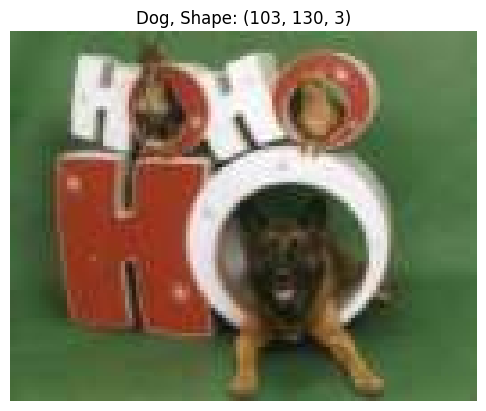

In [40]:
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
image_path_list = list(data_path.glob("*/*/*.jpg"))

random_image_path = random.choice(image_path_list)

image_class = random_image_path.parent.stem

img = Image.open(random_image_path)
img_is_array = np.asarray(img)

plt.imshow(img)
plt.axis(False)
plt.title(f"{image_class}, Shape: {img_is_array.shape}")

In [41]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [42]:
data_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_data_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [43]:
transformed_image = data_transform(img)
transformed_image

tensor([[[0.3882, 0.4000, 0.4118,  ..., 0.2784, 0.2941, 0.3098],
         [0.3804, 0.3961, 0.4078,  ..., 0.2784, 0.2902, 0.3059],
         [0.3765, 0.3922, 0.4039,  ..., 0.2745, 0.2824, 0.2941],
         ...,
         [0.3294, 0.3255, 0.3216,  ..., 0.2941, 0.2863, 0.2784],
         [0.3412, 0.3373, 0.3333,  ..., 0.3098, 0.2980, 0.2863],
         [0.3490, 0.3490, 0.3451,  ..., 0.3216, 0.3098, 0.2941]],

        [[0.5255, 0.5255, 0.5333,  ..., 0.4314, 0.4471, 0.4627],
         [0.5176, 0.5216, 0.5294,  ..., 0.4314, 0.4431, 0.4588],
         [0.5137, 0.5176, 0.5255,  ..., 0.4275, 0.4353, 0.4471],
         ...,
         [0.4745, 0.4784, 0.4784,  ..., 0.4392, 0.4314, 0.4235],
         [0.4706, 0.4902, 0.4902,  ..., 0.4549, 0.4431, 0.4314],
         [0.4627, 0.4980, 0.5020,  ..., 0.4667, 0.4549, 0.4392]],

        [[0.3451, 0.3529, 0.3608,  ..., 0.2471, 0.2627, 0.2784],
         [0.3373, 0.3490, 0.3569,  ..., 0.2471, 0.2588, 0.2745],
         [0.3333, 0.3451, 0.3529,  ..., 0.2431, 0.2510, 0.

Text(0.5, 1.0, 'Dog, Shape: torch.Size([3, 64, 64])')

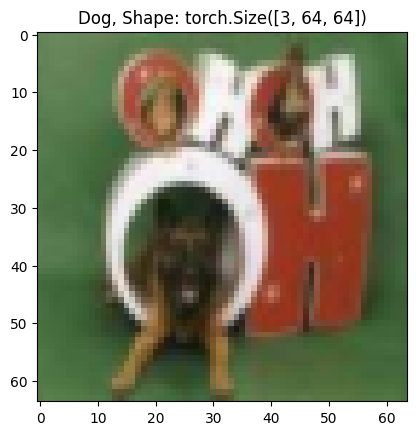

In [44]:
plt.imshow(transformed_image.permute(1, 2, 0))
plt.title(f"{image_class}, Shape: {transformed_image.shape}")

# Loading data using 'ImageFolder'

In [45]:
train_data = datasets.ImageFolder(root=train_path,
                                  transform=data_transform)

test_data = datasets.ImageFolder(root=test_path,
                                 transform=test_data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 7240
     Root location: data\train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 1756
     Root location: data\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

In [46]:
# Get class names as list
class_names = train_data.classes
class_names

['Cat', 'Dog']

In [47]:
# Get class names as dictionary 
class_dict = train_data.class_to_idx
class_dict

{'Cat': 0, 'Dog': 1}

In [48]:
len(train_data), len(test_data)

(7240, 1756)

# Turn loaded images into 'DataLoader'

In [49]:
BATCH_SIZE = 32
NUM_WORKERS = 0

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=NUM_WORKERS,
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x1fb49ac2a30>,
 <torch.utils.data.dataloader.DataLoader at 0x1fb130aa730>)

In [50]:
img_custom, label_custom = next(iter(train_dataloader))

img_custom.shape, label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [51]:
class DogVsCat(nn.Module):
    def __init__(self, input_shape, hidden_layers, output_shape):
        super().__init__()

        self.conv_block_layer_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_layers,
                      kernel_size=3,
                      padding=1,
                      stride=1),
            nn.BatchNorm2d(num_features=hidden_layers),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Conv2d(in_channels=hidden_layers,
                      out_channels=hidden_layers * 2,
                      kernel_size=3,
                      padding=1,
                      stride=1),
            nn.BatchNorm2d(num_features=hidden_layers*2),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )

        self.conv_block_layer_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_layers*2,
                      out_channels=hidden_layers*2*2,
                      kernel_size=3,
                      padding=1,
                      stride=1),
            nn.BatchNorm2d(num_features=hidden_layers*2*2),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Conv2d(in_channels=hidden_layers*2*2,
                      out_channels=hidden_layers*2*2*2,
                      kernel_size=3,
                      padding=1,
                      stride=1),
            nn.BatchNorm2d(num_features=hidden_layers*2*2*2),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )

        self.classification = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_layers*16*16*8,
                      #out_features=output_shape
                      out_features=128),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(128, output_shape)
        )

    def forward(self, x):
        #print(f"Shape: {x.shape}")
        x = self.conv_block_layer_1(x)
        #print(f"Shape: {x.shape}")
        x = self.conv_block_layer_2(x)
        #print(f"Shape: {x.shape}")
        x = self.classification(x)
        #print(f"Shape: {x.shape}")
        return x
        

In [52]:
model_0 = DogVsCat(input_shape=3, hidden_layers=16, output_shape=1).to(device)
model_0

DogVsCat(
  (conv_block_layer_1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_layer_2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6):

In [53]:
# Setup loss function and optimizer
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001)

loss_fn, optimizer

(BCEWithLogitsLoss(),
 Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     lr: 0.001
     maximize: False
     weight_decay: 0
 ))

In [54]:
# Check the correct shape on dummy tensor
dummy_input = torch.randn(32, 3, 64, 64)
output = model_0(dummy_input.to(device))
output

tensor([[ 0.1201],
        [-0.1684],
        [-0.0881],
        [ 0.0780],
        [ 0.4737],
        [-0.0429],
        [ 0.3601],
        [ 0.6277],
        [ 0.4349],
        [ 0.0901],
        [ 0.2401],
        [ 0.4893],
        [ 0.9093],
        [ 0.5239],
        [ 0.6686],
        [ 0.5864],
        [ 0.7464],
        [ 0.5017],
        [ 0.4874],
        [-0.1339],
        [ 0.1460],
        [ 0.4084],
        [ 0.4193],
        [-0.1215],
        [ 0.1010],
        [ 0.3678],
        [ 0.3589],
        [ 0.8740],
        [ 0.5102],
        [-0.0468],
        [ 0.1332],
        [ 0.1676]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [55]:
from tqdm import tqdm
import time

In [56]:
epochs = 1

start_time = time.time()

results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []}

for epoch in tqdm(range(epochs)):

    model_0.train()
    train_loss, train_acc = 0, 0
    
    for batch, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)

        y = y.unsqueeze(dim=1).float()
        
        y_pred = model_0(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        
        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        y_pred_class = (torch.sigmoid(y_pred) > 0.5).float()
        train_acc += (y_pred_class==y).sum().item() / len(y_pred)

    train_loss /= len(train_dataloader)
    train_acc = (train_acc / len(train_dataloader)) * 100
    
    model_0.eval()
    test_loss, test_acc = 0, 0
    
    with torch.inference_mode():
        for batch, (X, y) in enumerate(test_dataloader):
            X, y = X.to(device), y.to(device)

            y = y.unsqueeze(dim=1).float()
        
            test_pred = model_0(X)

            loss = loss_fn(test_pred, y)
            test_loss += loss.item()

            test_pred_class = (torch.sigmoid(test_pred) > 0.5).float()
            test_acc += (test_pred_class==y).sum().item() / len(test_pred)
    
        test_loss /= len(test_dataloader)
        test_acc = (test_acc / len(test_dataloader)) * 100

    print(f"Epoch: {epoch} | Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f} | Test Loss: {test_loss}, Test Accuracy: {test_acc}")

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)
    


end_time = time.time()
train_time = end_time - start_time

print(f"Total time: {train_time}")

100%|██████████| 1/1 [00:22<00:00, 22.33s/it]

Epoch: 0 | Train Loss: 1.1051, Train Accuracy: 55.15 | Test Loss: 0.6859137600118463, Test Accuracy: 52.10227272727273
Total time: 22.337299823760986


# Plot model_0 results

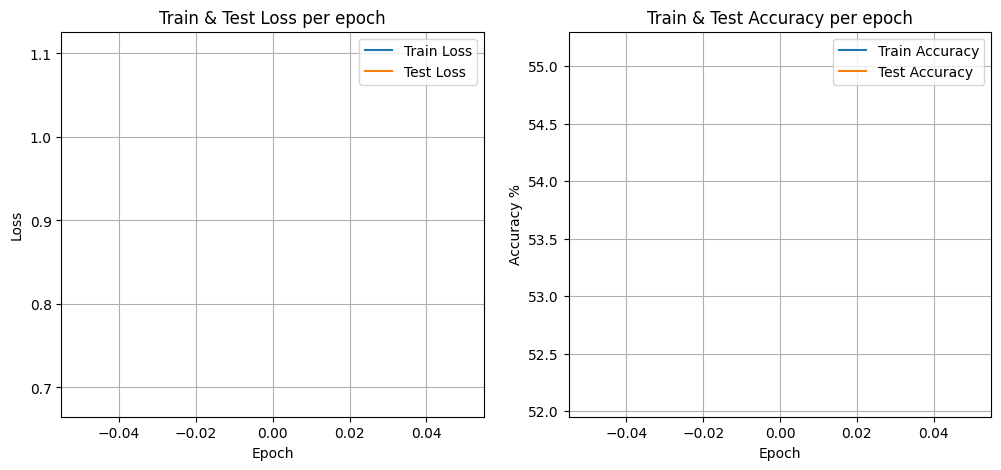

In [57]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(epochs), results["train_loss"], label="Train Loss")
plt.plot(range(epochs), results["test_loss"], label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train & Test Loss per epoch")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(range(epochs), results["train_acc"], label="Train Accuracy")
plt.plot(range(epochs), results["test_acc"], label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy %")
plt.title("Train & Test Accuracy per epoch")
plt.legend()
plt.grid()



In [58]:
print(len(results["train_loss"]), len(results["test_loss"]))
print(len(results["train_acc"]), len(results["test_acc"]))

1 1
1 1


In [59]:
# Build train and test function to make training easier
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim,
               device=device):

    train_loss, correct_preds, total_samples = 0, 0, 0
    model.train()

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y = y.unsqueeze(dim=1).float()
        
        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        
        optimizer.zero_grad()

        loss.backward()

        optimizer.step()
        
        y_pred_class = (torch.sigmoid(y_pred) > 0.5).float()
        #train_acc += (y_pred_class==y).sum().item() / len(y_pred)
        correct_preds += (y_pred_class == y).sum().item()
        total_samples += y.size(0)

    train_loss /= len(dataloader)
    #train_acc = (train_acc / len(dataloader)) * 100
    train_acc = (correct_preds / total_samples) * 100
    
    return train_loss, train_acc

In [60]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):

    test_loss, correct_preds, total_samples = 0, 0, 0
    model.eval()
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            y = y.unsqueeze(dim=1).float()
        
            test_pred = model(X)

            loss = loss_fn(test_pred, y)
            test_loss += loss.item()

            test_pred_class = (torch.sigmoid(test_pred) > 0.5).float()
            #test_acc += (test_pred_class==y).sum().item() / len(test_pred)
            correct_preds += (test_pred_class == y).sum().item()
            total_samples += y.size(0)
    
    test_loss /= len(dataloader)
    #test_acc = (test_acc / len(dataloader)) * 100
    test_acc = (correct_preds / total_samples) * 100
    return test_loss, test_acc

# Augmentation data

In [61]:
train_data_transform_augmentation = transforms.Compose([
    #transforms.Resize(size=(64, 64)),
    transforms.RandomResizedCrop(size=(64, 64), scale=(0.9, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=25),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
    #transforms.RandomAffine(degrees=15, translate=(1, 1)),
    #transforms.TrivialAugmentWide(num_magnitude_bins=31), # used to differentiate the data
    transforms.GaussianBlur(kernel_size=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

test_data = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])
train_data_transform_augmentation, test_data

(Compose(
     RandomResizedCrop(size=(64, 64), scale=(0.9, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
     RandomHorizontalFlip(p=0.5)
     RandomRotation(degrees=[-25.0, 25.0], interpolation=nearest, expand=False, fill=0)
     ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.05, 0.05))
     GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0))
     ToTensor()
     Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
 ),
 Compose(
     Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
     ToTensor()
     Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
 ))

In [62]:
train_data_augmentation = datasets.ImageFolder(root=train_path,
                                               transform=train_data_transform_augmentation)
test_data_augmentation = datasets.ImageFolder(root=test_path,
                                              transform=test_data)

train_data_augmentation, test_data_augmentation

(Dataset ImageFolder
     Number of datapoints: 7240
     Root location: data\train
     StandardTransform
 Transform: Compose(
                RandomResizedCrop(size=(64, 64), scale=(0.9, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
                RandomHorizontalFlip(p=0.5)
                RandomRotation(degrees=[-25.0, 25.0], interpolation=nearest, expand=False, fill=0)
                ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.05, 0.05))
                GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0))
                ToTensor()
                Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
            ),
 Dataset ImageFolder
     Number of datapoints: 1756
     Root location: data\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
                Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5

In [63]:
BATCH_SIZE = 32
NUM_WORKERS = 0

train_dataloader_augmentation = DataLoader(dataset=train_data_augmentation,
                                           batch_size=BATCH_SIZE,
                                           num_workers=NUM_WORKERS,
                                           shuffle=True)

test_dataloader_augmentation = DataLoader(dataset=test_data_augmentation,
                                          batch_size=BATCH_SIZE,
                                          num_workers=NUM_WORKERS,
                                          shuffle=False)

train_dataloader_augmentation, test_dataloader_augmentation

(<torch.utils.data.dataloader.DataLoader at 0x1fb13353520>,
 <torch.utils.data.dataloader.DataLoader at 0x1fb13363fd0>)

In [64]:
len(class_names)

2

In [65]:
model_1 = DogVsCat(input_shape=3, hidden_layers=8, output_shape=1).to(device)
model_1

DogVsCat(
  (conv_block_layer_1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_layer_2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU

In [66]:
# Setup loss function and optimizer
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)
                             #lr=0.00025)
#optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.01, momentum=0.9)
loss_fn, optimizer

(BCEWithLogitsLoss(),
 Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     lr: 0.001
     maximize: False
     weight_decay: 0
 ))

In [67]:
# Train model_1 on augmentation data
epochs = 100

start_time = time.time()

results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []}

for epoch in tqdm(range(epochs)):

    train_loss, train_acc = train_step(model=model_1,
               dataloader=train_dataloader_augmentation,
               loss_fn=loss_fn,
               optimizer=optimizer)

    test_loss, test_acc = test_step(model=model_1,
              dataloader=test_dataloader_augmentation,
              loss_fn=loss_fn)

    print(f"Epoch: {epoch} | Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f} | Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}")

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)
    


end_time = time.time()
train_time = end_time - start_time

print(f"Total time: {train_time}")

  1%|          | 1/100 [00:33<54:56, 33.29s/it]

Epoch: 0 | Train Loss: 0.8832, Train Accuracy: 52.73 | Test Loss: 0.6901, Test Accuracy: 51.94


  2%|▏         | 2/100 [01:15<1:02:41, 38.38s/it]

Epoch: 1 | Train Loss: 0.6873, Train Accuracy: 53.92 | Test Loss: 0.6829, Test Accuracy: 54.50


  3%|▎         | 3/100 [01:56<1:04:19, 39.79s/it]

Epoch: 2 | Train Loss: 0.6834, Train Accuracy: 54.49 | Test Loss: 0.6713, Test Accuracy: 57.74


  4%|▍         | 4/100 [02:37<1:04:20, 40.21s/it]

Epoch: 3 | Train Loss: 0.6665, Train Accuracy: 57.69 | Test Loss: 0.6482, Test Accuracy: 61.73


  5%|▌         | 5/100 [03:12<1:00:39, 38.31s/it]

Epoch: 4 | Train Loss: 0.6608, Train Accuracy: 58.81 | Test Loss: 0.6195, Test Accuracy: 67.82


  6%|▌         | 6/100 [03:50<59:45, 38.14s/it]  

Epoch: 5 | Train Loss: 0.6550, Train Accuracy: 61.55 | Test Loss: 0.6181, Test Accuracy: 70.22


  7%|▋         | 7/100 [04:30<59:59, 38.71s/it]

Epoch: 6 | Train Loss: 0.6554, Train Accuracy: 58.91 | Test Loss: 0.6278, Test Accuracy: 70.90


  8%|▊         | 8/100 [05:05<57:48, 37.70s/it]

Epoch: 7 | Train Loss: 0.6492, Train Accuracy: 61.82 | Test Loss: 0.6131, Test Accuracy: 69.82


  9%|▉         | 9/100 [05:40<55:36, 36.66s/it]

Epoch: 8 | Train Loss: 0.6417, Train Accuracy: 60.37 | Test Loss: 0.6204, Test Accuracy: 68.05


 10%|█         | 10/100 [06:17<55:27, 36.97s/it]

Epoch: 9 | Train Loss: 0.6435, Train Accuracy: 61.92 | Test Loss: 0.5824, Test Accuracy: 71.24


 11%|█         | 11/100 [06:57<56:14, 37.91s/it]

Epoch: 10 | Train Loss: 0.6349, Train Accuracy: 61.45 | Test Loss: 0.6096, Test Accuracy: 70.62


 12%|█▏        | 12/100 [07:35<55:24, 37.78s/it]

Epoch: 11 | Train Loss: 0.6401, Train Accuracy: 61.73 | Test Loss: 0.6084, Test Accuracy: 70.67


 13%|█▎        | 13/100 [08:13<54:47, 37.78s/it]

Epoch: 12 | Train Loss: 0.6298, Train Accuracy: 63.01 | Test Loss: 0.6059, Test Accuracy: 69.48


 14%|█▍        | 14/100 [08:54<55:52, 38.98s/it]

Epoch: 13 | Train Loss: 0.6261, Train Accuracy: 63.73 | Test Loss: 0.5733, Test Accuracy: 74.83


 15%|█▌        | 15/100 [09:36<56:32, 39.91s/it]

Epoch: 14 | Train Loss: 0.6220, Train Accuracy: 64.53 | Test Loss: 0.5653, Test Accuracy: 75.63


 16%|█▌        | 16/100 [10:20<57:13, 40.87s/it]

Epoch: 15 | Train Loss: 0.6175, Train Accuracy: 65.36 | Test Loss: 0.5685, Test Accuracy: 74.32


 17%|█▋        | 17/100 [11:01<57:00, 41.21s/it]

Epoch: 16 | Train Loss: 0.6142, Train Accuracy: 64.74 | Test Loss: 0.5801, Test Accuracy: 72.15


 18%|█▊        | 18/100 [11:45<57:12, 41.86s/it]

Epoch: 17 | Train Loss: 0.6094, Train Accuracy: 65.77 | Test Loss: 0.5744, Test Accuracy: 70.84


 19%|█▉        | 19/100 [12:30<57:38, 42.70s/it]

Epoch: 18 | Train Loss: 0.6053, Train Accuracy: 66.67 | Test Loss: 0.5609, Test Accuracy: 74.43


 20%|██        | 20/100 [13:08<55:09, 41.37s/it]

Epoch: 19 | Train Loss: 0.5907, Train Accuracy: 67.53 | Test Loss: 0.5528, Test Accuracy: 73.18


 21%|██        | 21/100 [13:51<55:09, 41.89s/it]

Epoch: 20 | Train Loss: 0.5896, Train Accuracy: 66.69 | Test Loss: 0.5479, Test Accuracy: 73.12


 22%|██▏       | 22/100 [14:32<54:07, 41.64s/it]

Epoch: 21 | Train Loss: 0.5906, Train Accuracy: 68.58 | Test Loss: 0.5416, Test Accuracy: 75.85


 23%|██▎       | 23/100 [15:11<52:35, 40.97s/it]

Epoch: 22 | Train Loss: 0.5852, Train Accuracy: 68.62 | Test Loss: 0.5396, Test Accuracy: 76.08


 24%|██▍       | 24/100 [15:53<52:00, 41.06s/it]

Epoch: 23 | Train Loss: 0.5757, Train Accuracy: 69.79 | Test Loss: 0.5458, Test Accuracy: 76.42


 25%|██▌       | 25/100 [16:32<50:40, 40.54s/it]

Epoch: 24 | Train Loss: 0.5726, Train Accuracy: 70.88 | Test Loss: 0.5458, Test Accuracy: 76.08


 26%|██▌       | 26/100 [17:12<49:37, 40.24s/it]

Epoch: 25 | Train Loss: 0.5692, Train Accuracy: 70.58 | Test Loss: 0.4959, Test Accuracy: 78.13


 27%|██▋       | 27/100 [17:51<48:39, 39.99s/it]

Epoch: 26 | Train Loss: 0.5593, Train Accuracy: 71.37 | Test Loss: 0.5062, Test Accuracy: 78.25


 28%|██▊       | 28/100 [18:33<48:43, 40.61s/it]

Epoch: 27 | Train Loss: 0.5585, Train Accuracy: 72.00 | Test Loss: 0.5076, Test Accuracy: 79.16


 29%|██▉       | 29/100 [19:15<48:26, 40.94s/it]

Epoch: 28 | Train Loss: 0.5529, Train Accuracy: 71.93 | Test Loss: 0.5078, Test Accuracy: 78.70


 30%|███       | 30/100 [19:58<48:33, 41.62s/it]

Epoch: 29 | Train Loss: 0.5484, Train Accuracy: 71.86 | Test Loss: 0.5056, Test Accuracy: 77.45


 31%|███       | 31/100 [20:40<47:59, 41.73s/it]

Epoch: 30 | Train Loss: 0.5587, Train Accuracy: 71.91 | Test Loss: 0.4842, Test Accuracy: 79.04


 32%|███▏      | 32/100 [21:23<47:43, 42.11s/it]

Epoch: 31 | Train Loss: 0.5487, Train Accuracy: 72.14 | Test Loss: 0.4972, Test Accuracy: 79.10


 33%|███▎      | 33/100 [22:04<46:47, 41.90s/it]

Epoch: 32 | Train Loss: 0.5410, Train Accuracy: 73.01 | Test Loss: 0.4990, Test Accuracy: 78.99


 34%|███▍      | 34/100 [22:46<46:03, 41.87s/it]

Epoch: 33 | Train Loss: 0.5423, Train Accuracy: 73.18 | Test Loss: 0.4634, Test Accuracy: 79.84


 35%|███▌      | 35/100 [23:26<44:41, 41.25s/it]

Epoch: 34 | Train Loss: 0.5412, Train Accuracy: 73.25 | Test Loss: 0.4952, Test Accuracy: 79.90


 36%|███▌      | 36/100 [23:59<41:24, 38.83s/it]

Epoch: 35 | Train Loss: 0.5375, Train Accuracy: 73.73 | Test Loss: 0.4714, Test Accuracy: 80.47


 37%|███▋      | 37/100 [24:42<41:58, 39.98s/it]

Epoch: 36 | Train Loss: 0.5318, Train Accuracy: 73.49 | Test Loss: 0.5094, Test Accuracy: 78.47


 38%|███▊      | 38/100 [25:25<42:24, 41.04s/it]

Epoch: 37 | Train Loss: 0.5281, Train Accuracy: 73.62 | Test Loss: 0.4720, Test Accuracy: 81.26


 39%|███▉      | 39/100 [26:07<41:54, 41.22s/it]

Epoch: 38 | Train Loss: 0.5247, Train Accuracy: 74.13 | Test Loss: 0.4492, Test Accuracy: 81.55


 40%|████      | 40/100 [26:50<41:39, 41.66s/it]

Epoch: 39 | Train Loss: 0.5300, Train Accuracy: 73.60 | Test Loss: 0.4534, Test Accuracy: 80.64


 41%|████      | 41/100 [27:32<41:10, 41.88s/it]

Epoch: 40 | Train Loss: 0.5282, Train Accuracy: 74.34 | Test Loss: 0.4812, Test Accuracy: 77.51


 42%|████▏     | 42/100 [28:14<40:39, 42.05s/it]

Epoch: 41 | Train Loss: 0.5204, Train Accuracy: 74.45 | Test Loss: 0.4471, Test Accuracy: 81.15


 43%|████▎     | 43/100 [28:58<40:23, 42.52s/it]

Epoch: 42 | Train Loss: 0.5245, Train Accuracy: 74.86 | Test Loss: 0.4220, Test Accuracy: 81.72


 44%|████▍     | 44/100 [29:37<38:47, 41.56s/it]

Epoch: 43 | Train Loss: 0.5202, Train Accuracy: 74.59 | Test Loss: 0.4580, Test Accuracy: 79.16


 45%|████▌     | 45/100 [30:12<36:15, 39.56s/it]

Epoch: 44 | Train Loss: 0.5225, Train Accuracy: 74.06 | Test Loss: 0.4277, Test Accuracy: 81.55


 46%|████▌     | 46/100 [30:56<36:40, 40.75s/it]

Epoch: 45 | Train Loss: 0.5184, Train Accuracy: 74.25 | Test Loss: 0.4514, Test Accuracy: 80.69


 47%|████▋     | 47/100 [31:39<36:35, 41.43s/it]

Epoch: 46 | Train Loss: 0.5190, Train Accuracy: 74.41 | Test Loss: 0.4302, Test Accuracy: 82.18


 48%|████▊     | 48/100 [32:19<35:30, 40.98s/it]

Epoch: 47 | Train Loss: 0.5102, Train Accuracy: 75.55 | Test Loss: 0.4307, Test Accuracy: 81.26


 49%|████▉     | 49/100 [32:55<33:37, 39.56s/it]

Epoch: 48 | Train Loss: 0.5082, Train Accuracy: 75.59 | Test Loss: 0.4530, Test Accuracy: 81.38


 50%|█████     | 50/100 [33:38<33:56, 40.74s/it]

Epoch: 49 | Train Loss: 0.5044, Train Accuracy: 75.48 | Test Loss: 0.4213, Test Accuracy: 81.89


 51%|█████     | 51/100 [34:22<33:56, 41.57s/it]

Epoch: 50 | Train Loss: 0.5016, Train Accuracy: 75.03 | Test Loss: 0.4425, Test Accuracy: 82.12


 52%|█████▏    | 52/100 [35:04<33:20, 41.68s/it]

Epoch: 51 | Train Loss: 0.5050, Train Accuracy: 75.43 | Test Loss: 0.4384, Test Accuracy: 81.66


 53%|█████▎    | 53/100 [35:45<32:23, 41.36s/it]

Epoch: 52 | Train Loss: 0.4969, Train Accuracy: 76.48 | Test Loss: 0.4293, Test Accuracy: 81.44


 54%|█████▍    | 54/100 [36:24<31:20, 40.88s/it]

Epoch: 53 | Train Loss: 0.4961, Train Accuracy: 76.19 | Test Loss: 0.4345, Test Accuracy: 81.15


 55%|█████▌    | 55/100 [37:06<30:52, 41.17s/it]

Epoch: 54 | Train Loss: 0.5011, Train Accuracy: 75.91 | Test Loss: 0.4160, Test Accuracy: 81.66


 56%|█████▌    | 56/100 [37:48<30:16, 41.28s/it]

Epoch: 55 | Train Loss: 0.4978, Train Accuracy: 75.91 | Test Loss: 0.4189, Test Accuracy: 82.18


 57%|█████▋    | 57/100 [38:30<29:45, 41.52s/it]

Epoch: 56 | Train Loss: 0.4980, Train Accuracy: 76.56 | Test Loss: 0.4088, Test Accuracy: 82.29


 58%|█████▊    | 58/100 [39:12<29:17, 41.85s/it]

Epoch: 57 | Train Loss: 0.4882, Train Accuracy: 76.92 | Test Loss: 0.4074, Test Accuracy: 82.23


 59%|█████▉    | 59/100 [39:49<27:28, 40.21s/it]

Epoch: 58 | Train Loss: 0.4874, Train Accuracy: 77.02 | Test Loss: 0.4322, Test Accuracy: 81.04


 60%|██████    | 60/100 [40:30<27:05, 40.64s/it]

Epoch: 59 | Train Loss: 0.4903, Train Accuracy: 76.63 | Test Loss: 0.4006, Test Accuracy: 84.00


 61%|██████    | 61/100 [41:05<25:20, 38.98s/it]

Epoch: 60 | Train Loss: 0.4908, Train Accuracy: 76.28 | Test Loss: 0.4319, Test Accuracy: 81.66


 62%|██████▏   | 62/100 [41:39<23:37, 37.31s/it]

Epoch: 61 | Train Loss: 0.4901, Train Accuracy: 76.99 | Test Loss: 0.4157, Test Accuracy: 82.97


 63%|██████▎   | 63/100 [42:16<22:55, 37.17s/it]

Epoch: 62 | Train Loss: 0.4891, Train Accuracy: 76.71 | Test Loss: 0.4094, Test Accuracy: 83.09


 64%|██████▍   | 64/100 [42:59<23:27, 39.10s/it]

Epoch: 63 | Train Loss: 0.4885, Train Accuracy: 77.03 | Test Loss: 0.4253, Test Accuracy: 82.29


 65%|██████▌   | 65/100 [43:42<23:24, 40.14s/it]

Epoch: 64 | Train Loss: 0.4785, Train Accuracy: 77.97 | Test Loss: 0.4082, Test Accuracy: 83.31


 66%|██████▌   | 66/100 [44:18<22:04, 38.96s/it]

Epoch: 65 | Train Loss: 0.4826, Train Accuracy: 77.10 | Test Loss: 0.3896, Test Accuracy: 83.66


 67%|██████▋   | 67/100 [44:51<20:22, 37.05s/it]

Epoch: 66 | Train Loss: 0.4942, Train Accuracy: 76.48 | Test Loss: 0.3933, Test Accuracy: 84.05


 68%|██████▊   | 68/100 [45:33<20:34, 38.59s/it]

Epoch: 67 | Train Loss: 0.4882, Train Accuracy: 76.60 | Test Loss: 0.3947, Test Accuracy: 83.83


 69%|██████▉   | 69/100 [46:07<19:17, 37.34s/it]

Epoch: 68 | Train Loss: 0.4781, Train Accuracy: 77.20 | Test Loss: 0.3866, Test Accuracy: 83.94


 70%|███████   | 70/100 [46:46<18:47, 37.60s/it]

Epoch: 69 | Train Loss: 0.4753, Train Accuracy: 77.94 | Test Loss: 0.3944, Test Accuracy: 83.77


 71%|███████   | 71/100 [47:28<18:50, 38.98s/it]

Epoch: 70 | Train Loss: 0.4798, Train Accuracy: 77.31 | Test Loss: 0.3776, Test Accuracy: 83.26


 72%|███████▏  | 72/100 [48:11<18:46, 40.24s/it]

Epoch: 71 | Train Loss: 0.4825, Train Accuracy: 77.17 | Test Loss: 0.3825, Test Accuracy: 83.14


 73%|███████▎  | 73/100 [48:54<18:32, 41.19s/it]

Epoch: 72 | Train Loss: 0.4750, Train Accuracy: 78.07 | Test Loss: 0.4031, Test Accuracy: 83.09


 74%|███████▍  | 74/100 [49:36<17:58, 41.47s/it]

Epoch: 73 | Train Loss: 0.4761, Train Accuracy: 77.61 | Test Loss: 0.4039, Test Accuracy: 82.06


 75%|███████▌  | 75/100 [50:11<16:23, 39.34s/it]

Epoch: 74 | Train Loss: 0.4670, Train Accuracy: 77.31 | Test Loss: 0.3857, Test Accuracy: 84.97


 76%|███████▌  | 76/100 [50:52<15:55, 39.83s/it]

Epoch: 75 | Train Loss: 0.4794, Train Accuracy: 77.29 | Test Loss: 0.3971, Test Accuracy: 82.69


 77%|███████▋  | 77/100 [51:35<15:42, 40.98s/it]

Epoch: 76 | Train Loss: 0.4824, Train Accuracy: 77.67 | Test Loss: 0.3785, Test Accuracy: 83.94


 78%|███████▊  | 78/100 [52:19<15:19, 41.78s/it]

Epoch: 77 | Train Loss: 0.4675, Train Accuracy: 78.18 | Test Loss: 0.3849, Test Accuracy: 81.72


 79%|███████▉  | 79/100 [53:01<14:35, 41.68s/it]

Epoch: 78 | Train Loss: 0.4651, Train Accuracy: 78.15 | Test Loss: 0.4059, Test Accuracy: 82.69


 80%|████████  | 80/100 [53:42<13:51, 41.60s/it]

Epoch: 79 | Train Loss: 0.4692, Train Accuracy: 77.69 | Test Loss: 0.3693, Test Accuracy: 85.25


 81%|████████  | 81/100 [54:25<13:21, 42.16s/it]

Epoch: 80 | Train Loss: 0.4669, Train Accuracy: 78.04 | Test Loss: 0.4000, Test Accuracy: 82.69


 82%|████████▏ | 82/100 [55:07<12:36, 42.01s/it]

Epoch: 81 | Train Loss: 0.4649, Train Accuracy: 78.27 | Test Loss: 0.3961, Test Accuracy: 83.37


 83%|████████▎ | 83/100 [55:41<11:11, 39.51s/it]

Epoch: 82 | Train Loss: 0.4630, Train Accuracy: 78.62 | Test Loss: 0.3851, Test Accuracy: 83.43


 84%|████████▍ | 84/100 [56:21<10:33, 39.59s/it]

Epoch: 83 | Train Loss: 0.4664, Train Accuracy: 77.89 | Test Loss: 0.4185, Test Accuracy: 78.53


 85%|████████▌ | 85/100 [56:56<09:36, 38.42s/it]

Epoch: 84 | Train Loss: 0.4733, Train Accuracy: 77.78 | Test Loss: 0.3850, Test Accuracy: 83.37


 86%|████████▌ | 86/100 [57:36<09:04, 38.90s/it]

Epoch: 85 | Train Loss: 0.4582, Train Accuracy: 78.54 | Test Loss: 0.3821, Test Accuracy: 84.85


 87%|████████▋ | 87/100 [58:20<08:44, 40.36s/it]

Epoch: 86 | Train Loss: 0.4517, Train Accuracy: 78.63 | Test Loss: 0.3714, Test Accuracy: 83.37


 88%|████████▊ | 88/100 [59:03<08:15, 41.29s/it]

Epoch: 87 | Train Loss: 0.4735, Train Accuracy: 77.44 | Test Loss: 0.3613, Test Accuracy: 84.05


 89%|████████▉ | 89/100 [59:47<07:42, 42.09s/it]

Epoch: 88 | Train Loss: 0.4613, Train Accuracy: 78.09 | Test Loss: 0.3819, Test Accuracy: 84.97


 90%|█████████ | 90/100 [1:00:32<07:07, 42.72s/it]

Epoch: 89 | Train Loss: 0.4556, Train Accuracy: 78.55 | Test Loss: 0.3689, Test Accuracy: 85.19


 91%|█████████ | 91/100 [1:01:10<06:12, 41.38s/it]

Epoch: 90 | Train Loss: 0.4534, Train Accuracy: 78.26 | Test Loss: 0.3762, Test Accuracy: 84.28


 92%|█████████▏| 92/100 [1:01:48<05:23, 40.41s/it]

Epoch: 91 | Train Loss: 0.4503, Train Accuracy: 79.30 | Test Loss: 0.3866, Test Accuracy: 84.17


 93%|█████████▎| 93/100 [1:02:22<04:28, 38.39s/it]

Epoch: 92 | Train Loss: 0.4585, Train Accuracy: 78.23 | Test Loss: 0.3746, Test Accuracy: 84.05


 94%|█████████▍| 94/100 [1:03:01<03:52, 38.73s/it]

Epoch: 93 | Train Loss: 0.4507, Train Accuracy: 78.49 | Test Loss: 0.3633, Test Accuracy: 85.14


 95%|█████████▌| 95/100 [1:03:39<03:11, 38.39s/it]

Epoch: 94 | Train Loss: 0.4464, Train Accuracy: 79.02 | Test Loss: 0.3705, Test Accuracy: 84.00


 96%|█████████▌| 96/100 [1:04:17<02:32, 38.24s/it]

Epoch: 95 | Train Loss: 0.4559, Train Accuracy: 78.11 | Test Loss: 0.3803, Test Accuracy: 84.57


 97%|█████████▋| 97/100 [1:04:55<01:54, 38.26s/it]

Epoch: 96 | Train Loss: 0.4591, Train Accuracy: 78.15 | Test Loss: 0.3977, Test Accuracy: 81.15


 98%|█████████▊| 98/100 [1:05:33<01:16, 38.24s/it]

Epoch: 97 | Train Loss: 0.4530, Train Accuracy: 78.62 | Test Loss: 0.3896, Test Accuracy: 83.60


 99%|█████████▉| 99/100 [1:06:12<00:38, 38.46s/it]

Epoch: 98 | Train Loss: 0.4506, Train Accuracy: 78.85 | Test Loss: 0.3645, Test Accuracy: 84.91


100%|██████████| 100/100 [1:06:51<00:00, 40.11s/it]

Epoch: 99 | Train Loss: 0.4620, Train Accuracy: 78.34 | Test Loss: 0.3767, Test Accuracy: 85.42
Total time: 4011.2629969120026


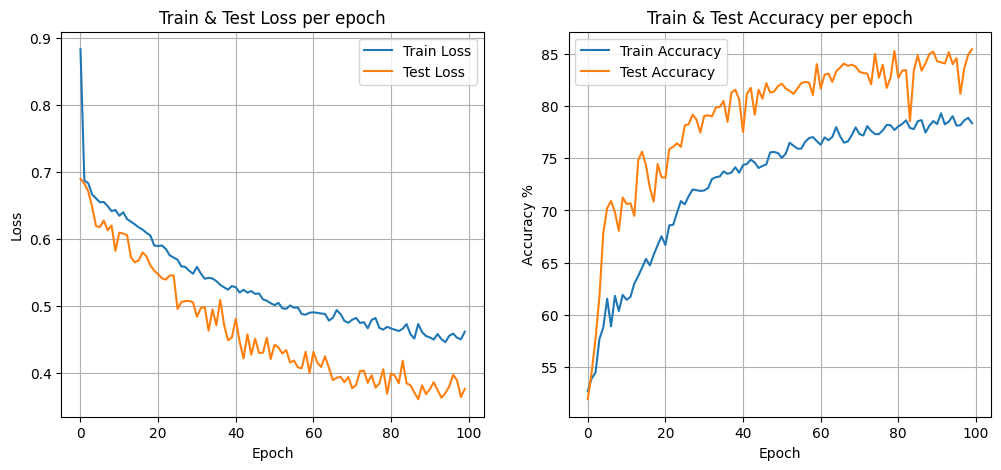

In [68]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(epochs), results["train_loss"], label="Train Loss")
plt.plot(range(epochs), results["test_loss"], label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train & Test Loss per epoch")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(range(epochs), results["train_acc"], label="Train Accuracy")
plt.plot(range(epochs), results["test_acc"], label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy %")
plt.title("Train & Test Accuracy per epoch")
plt.legend()
plt.grid()

In [69]:
from torch.utils.data import Subset

In [70]:
train_100_images = Subset(train_data_augmentation, range(100))
test_20_images = Subset(test_data_augmentation, range(20))

len(train_100_images), len(test_20_images)

(100, 20)